Please create a folder named `data` in the main directory and place the following files inside it:

- `Reddit-Threads_2020-2021.csv`
- `Reddit-Threads_2022-2023.csv`

In [11]:
# Standard Library Imports
import os
import json
import time
import random
from dotenv import load_dotenv

# Data Handling
import pandas as pd
import numpy as np
from datasets import Dataset

# NLP and Transformers
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from nltk.corpus import stopwords
import torch
import torch.nn as nn
from sklearn.metrics import f1_score

# API and Hugging Face Integration
import requests
from huggingface_hub import login

# AI APIs
import google.generativeai as genai
from googleapiclient import discovery
from openai import OpenAI

# Visualization
import matplotlib.pyplot as plt

# Utilities
from tqdm import tqdm
import ast

# huggingface API key
hf_api_key = os.getenv('HUGGINGFACE_API_KEY')
login(token=hf_api_key)

if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(torch.cuda.current_device())
    print(f'Device in use: {device_name}')
else:
    device = torch.device("cpu")
    print('Device in use: CPU')

load_dotenv()

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to C:\Users\caboo\.cache\huggingface\token
Login successful
Device in use: NVIDIA GeForce RTX 3080 Laptop GPU


True

# Reading in data

In [3]:
df = pd.DataFrame()

###   SMALL DATASET   ###
# df = pd.read_csv('data/Reddit-Threads_2020-2021.csv', nrows=10000)
# print(df.head())
###   SMALL DATASET   ###

###   FULL DATASET   ###
# chunk_size = 10000
# for chunk in pd.read_csv('data/Reddit-Threads_2020-2021.csv', chunksize=chunk_size):
#     print(chunk.head())  
#     df = pd.concat([df, chunk])
# for chunk in pd.read_csv('data/Reddit-Threads_2022-2023.csv', chunksize=chunk_size):
#     print(chunk.head())  
#     df = pd.concat([df, chunk])
###   FULL DATASET   ###

###   VALIDATION DATASET   ###
df = pd.read_csv('data/labeled_data_2.csv')
df['combined'] = df['hateful'] | df['toxic']
print(df.head())

print(df.shape)


                                                text        timestamp  \
0     Expensive eh now that Uglyfoods closed down :(   30/1/2023 1:04   
1                How dare you.. wan go lim kopi ah??   4/5/2022 18:57   
2  Yeah the governments can politick all they wan...  28/6/2022 13:44   
3               Hijacks event, then complains. Wild.   12/7/2022 7:29   
4  Hate to break it to you. But once someone accu...   23/8/2023 2:08   

              username                                               link  \
0      MangoDangoLango  /r/singapore/comments/10nqt5h/rsingapore_rando...   
1               900122  /r/SingaporeRaw/comments/ui0rmg/dont_take_offe...   
2  DisillusionedSinkie  /r/singapore/comments/vmb197/malaysias_top_tal...   
3            nehjipain  /r/singapore/comments/vx42x1/nus_student_tried...   
4          KeenStudent  /r/singapore/comments/15ybdme/sorry_doesnt_cut...   

      link_id   parent_id       id subreddit_id  \
0  t3_10nqt5h  t1_j6dwxo8  j6fuv4x     t5_2qh8c

# Cleaning

In [13]:
df['moderation'] = df['moderation'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
moderation_dicts = df['moderation']
moderation_normalized = pd.json_normalize(moderation_dicts)
# print(moderation_normalized)
df = df.reset_index(drop=True)
moderation_normalized = moderation_normalized.reset_index(drop=True)
df_normalized = pd.concat([df.drop(columns=['moderation']), moderation_normalized], axis=1)
# print(df_normalized.columns)
# df_normalized = df

### removing deleted or removed text ###
df_normalized = df_normalized[df_normalized['text'] != '[deleted]']
df_normalized = df_normalized[df_normalized['text'] != '[removed]']
df_normalized = df_normalized.dropna(subset=['text'])
### removing deleted or removed text ###

### stop word removal ###
# stop_words = set(stopwords.words('english'))

# def remove_stop_words(text):
#     if isinstance(text, str):  # Check if the text is a string
#         return ' '.join([word for word in text.split() if word.lower() not in stop_words])
#     return text 

# df_normalized['text'] = df_normalized['text'].apply(remove_stop_words)
# print(df_normalized['text'])
# print(stop_words)
### stop word removal ###



C:\Users\caboo\AppData\Local\Temp\ipykernel_5044\628181459.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Not specified' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_for_plot.fillna('Not specified', inplace=True)


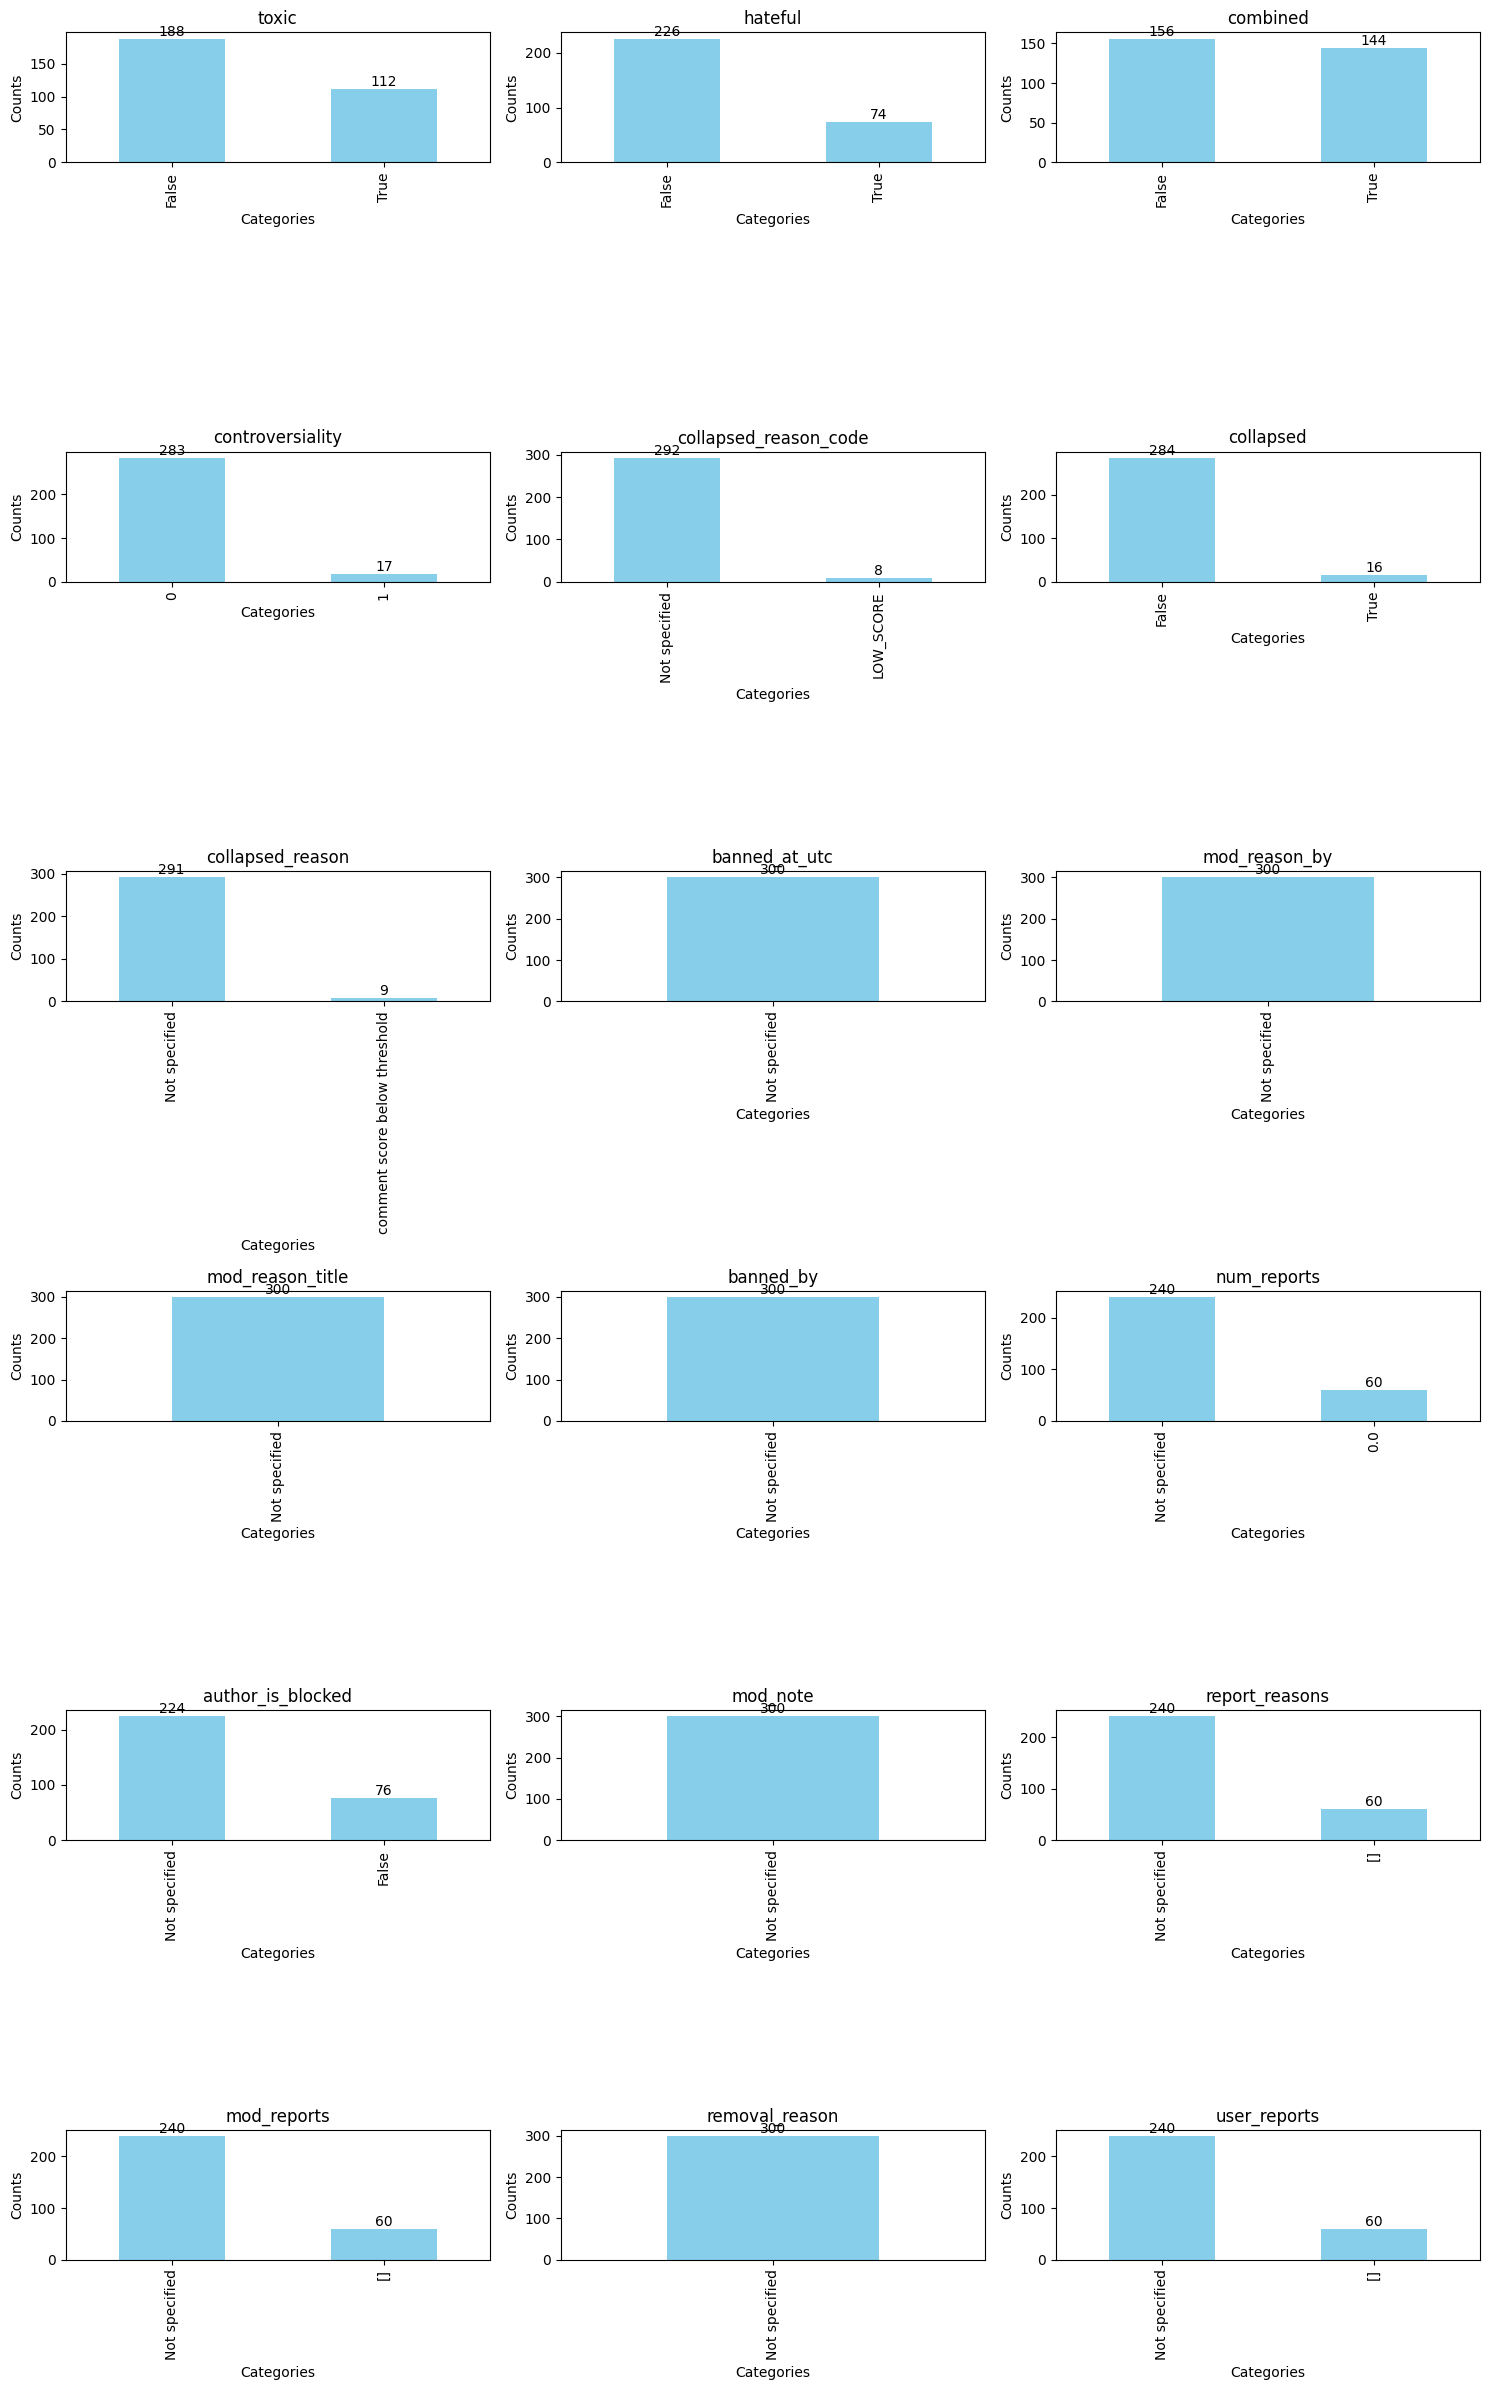

In [14]:
df_for_plot = df_normalized.copy()
df_for_plot.fillna('Not specified', inplace=True)


exclude_columns = [
    'text', 
    'timestamp', 
    'username', 
    'link', 
    'link_id', 
    'parent_id', 
    'id', 
    'subreddit_id'
]
columns_to_plot = [col for col in df_normalized.columns if col not in exclude_columns]


num_columns = len(columns_to_plot)
cols = 3  
rows = (num_columns + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    counts = df_for_plot[column].value_counts()
    if not counts.empty:
        bars = counts.plot(kind='bar', ax=axes[i], color='skyblue')
        axes[i].set_title(column)
        axes[i].set_xlabel('Categories')
        axes[i].set_ylabel('Counts')

        for bar in bars.patches:
            axes[i].annotate(format(int(bar.get_height())), 
                                (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                                ha='center', va='bottom')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  
plt.show()

# 2 Finding the best labeller
https://huggingface.co/sileod/deberta-v3-base-tasksource-toxicity

after testing with the following models:<br>
with the threshold at 0 meaning 100% True or if not 1 False and 299 True<br>
As sileod/deberta-v3-base-tasksource-toxicity has a relatively high f1 score and a takes a relatively low time to label the text data, we decided to use it. <br>
| Model Name                                                                              | Best F1 Score               | Threshold | Time           |
|-----------------------------------------------------------------------------------------|-----------------------------|-----------|----------------|
| sileod/deberta-v3-base-tasksource-toxicity                                               | 0.6750788643533123           | 0.01      | 11s            |
| unitary/toxic-bert                                                                       | 0.6486486486486487           | 0.0       | 4s             |
| GroNLP/hateBERT                                                                          | 0.6486486486486487           | 0.0       | 4s             |
| textdetox/xlmr-large-toxicity-classifier                                                 | 0.6455981941309256           | 0.0       | 4s             |
| facebook/roberta-hate-speech-dynabench-r4-target                                         | 0.6455981941309256           | 0.0       | 4s             |
| cointegrated/rubert-tiny-toxicity                                                        | 0.6455981941309256           | 0.0       | 1s             |
| badmatr11x/distilroberta-base-offensive-hateful-speech-text-multiclassification          | 0.6455981941309256           | 0.0       | 2s             |
| Llama-3.2-1B-Instruct                                                                    | 0.2702702702702703           | -         | 27s            |
| meta-llama/Llama-3.2-3B-Instruct                                                         | 0.49777777777777776          | -         | 12 mins 1s     |
| Perspective API                                                                          | 0.42424242424242425          | -         | 6 mins 20s     |
| aisingapore/llama3-8b-cpt-sea-lionv2.1-instruct                                          | 0.5178571428571429           | -         | 1h 15 mins 13s    |
| GANgstersDev/singlish-hate-offensive-finetuned-model-v2.0.1                              | 0.6045340050377834           | -         | 15s            |
| citizenlab/distilbert-base-multilingual-cased-toxicity                                   | 0.46551724137931033          | 0.1       | 7s             |



### 2.1 code for most BERT models

In [17]:
# Choose model here
model = 'unitary/toxic-bert'

# Initialize the hate classifier
pipe = pipeline("text-classification", model=model, return_all_scores=True, device=device)

# Create a list to store the predicted scores for each text
df_normalized['temp_score'] = np.nan  # To store the hate score

# Create a list to store the actual hate labels (for F1 score calculation)
true_labels = df_normalized['hateful'] | df_normalized['toxic'] # Assuming 'hateful' is the ground truth column

test_response = pipe("I hate you")
# import pdb; pdb.set_trace()

# Process the texts and save the prediction scores
for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying:"):
    text = row['text']
    
    # Skip invalid texts
    if not isinstance(text, str) or text.strip() == "":
        print(f"Invalid text at index {index}. Skipping row.")
        continue

    try:
        # Get predictions from pipe
        prediction = pipe(text)
        
        # Extract the score for 'hate' label
        for pred in prediction[0]:
            label = pred['label']
            score = pred['score']
            if label == 'toxic':  # Store the hate score
                df_normalized.at[index, 'temp_score'] = score
                break

    except Exception as e:
        print(f"Error processing hate speech at index {index}: {e}")

# Function to calculate F1 score for different thresholds
def calculate_f1_for_threshold(df, threshold):
    # Predict 'True' for hate if the score is above the threshold
    predicted_labels = df['temp_score'].apply(lambda x: True if x >= threshold else False)
    return f1_score(true_labels, predicted_labels)

# Search for the best threshold by calculating F1 score for different thresholds
thresholds = np.linspace(0, 1, 101)  # Try thresholds between 0 and 1 in 0.01 increments
best_threshold = 0
best_f1 = 0

for threshold in thresholds:
    f1 = calculate_f1_for_threshold(df_normalized, threshold)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best Threshold: {best_threshold}, Best F1 Score: {best_f1}")

# Apply the best threshold to label texts as hateful or not
df_normalized['temp'] = df_normalized['temp_score'] >= best_threshold

# Print the final counts of hateful and non-hateful texts
print(df_normalized['temp'].value_counts())

del pipe


c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Classifying:: 100%|██████████| 300/300 [00:04<00:00, 71.11it/s]


Best Threshold: 0.0, Best F1 Score: 0.6486486486486487
temp
True    300
Name: count, dtype: int64


### 3.2 code for Llama instruct models

In [5]:
pipe = pipeline("text-generation", model='meta-llama/Llama-3.2-1B-Instruct', device_map='auto')

In [6]:
for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying toxicity and hatefulness"):
    text = row['text']
    messages = [
        {"role": "system", "content": "You are a moderator on the subreddit r/Singapore. You are reviewing a user's comment to determine if it is toxic or hateful. Please respond with only False (not toxic or hateful) or True (very toxic or hateful) for the following comment."},
        {"role": "user", "content": text},
    ]
    response = pipe(messages, max_new_tokens=50, do_sample=False, truncation=True)
    df_normalized.at[index, 'Llama_combined'] = (response[0]['generated_text'][2]['content'] == 'True')

df_normalized['Llama_combined'] = df_normalized['Llama_combined'].astype(bool)

Classifying toxicity and hatefulness:   0%|          | 0/300 [00:00<?, ?it/s]c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\models\llama\modeling_llama.py:655: UserWarning: 1Torch was not compiled with flash attention

In [7]:
print(df_normalized['Llama_combined'].value_counts())
print(df_normalized['combined'].value_counts())
f1 = f1_score(df_normalized['combined'], df_normalized['Llama_combined'])
print(f"F1 Score: {f1}")

Llama_combined
False    222
True      78
Name: count, dtype: int64
combined
False    156
True     144
Name: count, dtype: int64
F1 Score: 0.2702702702702703


In [8]:
del pipe

### 3.3 code for Perspective API
set-up guide: https://developers.google.com/codelabs/setup-perspective-api#0

In [11]:
API_KEY = os.getenv('GOOGLE_API_KEY')
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "dsa4264-toxcity-and-hate-b0f323f77cc1.json"

client = discovery.build(
  "commentanalyzer",
  "v1alpha1",
  developerKey=API_KEY,
  discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
  static_discovery=False,
)

In [12]:
df_normalized['perspective'] = False

for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying toxicity"):
    text = row['text']

    analyze_request = {
        'comment': {'text': text},
        'requestedAttributes': {
            'TOXICITY': {},
            'SEVERE_TOXICITY': {},
            'INSULT': {},
            'IDENTITY_ATTACK': {}
        },
        'languages': ['en']  # Specify language as English
    }

    
    response = client.comments().analyze(body=analyze_request).execute()

    toxicity_score = response['attributeScores']['TOXICITY']['summaryScore']['value']
    severe_toxicity_score = response['attributeScores']['SEVERE_TOXICITY']['summaryScore']['value']
    insult_score = response['attributeScores']['INSULT']['summaryScore']['value']
    identity_attack_score = response['attributeScores']['IDENTITY_ATTACK']['summaryScore']['value']

    if toxicity_score > 0.5 or severe_toxicity_score > 0.5 or insult_score > 0.5 or identity_attack_score > 0.5:
        df_normalized.at[index, 'perspective'] = True

    time.sleep(1) #needed as the API has a rate limit of 60 requests per minute


Classifying toxicity: 100%|██████████| 300/300 [06:20<00:00,  1.27s/it]


In [13]:
f1_score = f1_score(df_normalized['combined'], df_normalized['perspective'])
print(f"F1 Score: {f1_score}")

F1 Score: 0.42424242424242425


In [56]:
df_normalized['perspective_toxic'].value_counts()

perspective_toxic
False    248
True      52
Name: count, dtype: int64

### 3.4 code for GANgstersDev/singlish-hate-offensive-finetuned-model-v2.0.1

In [6]:

model_name = "GANgstersDev/singlish-hate-offensive-finetuned-model-v2.0.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)


def classify_text(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    
    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get the predicted class
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=1).item()
    
    # Map class ID to class label
    class_labels = ["neither", "offensive", "hate"]  # Adjust according to your labels
    predicted_class_label = class_labels[predicted_class_id]
    
    return predicted_class_label


# Load the model and tokenizer
model_name = "GANgstersDev/singlish-hate-offensive-finetuned-model-v2.0.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Define function to classify text and return JSON output
def classify_text(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    
    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get the predicted class
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=1).item()
    
    # Map class ID to class label
    class_labels = ["neither", "offensive", "hate"]  # Adjust according to your labels
    predicted_class_label = class_labels[predicted_class_id]
    
    # Get the category scores
    category_scores = torch.softmax(logits, dim=1).numpy().flatten()
    
    # Create JSON output
    result = {
        "text": text,
        "predicted_label": predicted_class_label,
        "scores": {label: float(score) for label, score in zip(class_labels, category_scores)}
    }
    
    return result

# Example usage

for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying toxicity"):
    text = row['text']
    
    # Classify the text using your model
    result = classify_text(text)
    
    # Check if the predicted label is 'hate' or 'offensive'
    if result['predicted_label'] == 'hate' or result['predicted_label'] == 'offensive':
        df_normalized.at[index, 'ganster'] = True
    else:
        df_normalized.at[index, 'ganster'] = False


Classifying toxicity: 100%|██████████| 300/300 [00:15<00:00, 19.42it/s]


In [9]:
df_normalized['ganster'] = df_normalized['ganster'].astype(bool)
print(f1_score(df_normalized['combined'], df_normalized['ganster']))

0.6045340050377834


In [ ]:
del tokenizer
del model